In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

In [215]:
pd.set_option('display.max_columns', 200)
df = pd.read_csv('preprocessed.csv')
df.head()

,Unnamed: 0,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,0,5,1,1,41,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,1,15,3,9,59,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
2,2,25,2,6,11,5,13,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

Since preprocessed file included all original columns plus the one-hot features, we can only select the columns that we need for training our model:

In [216]:
df = df.drop(df.columns[0],axis=1)
print(df.shape)
df.head()

(99340, 170)


,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,5,1,1,41,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,15,3,9,59,0,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
2,25,2,6,11,5,13,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [217]:
# input features
# X = df.iloc[:,:-3]
# # labels
# y = df.iloc[:,-3:]

df_train, df_valtest = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_valtest, test_size=0.5, random_state=42)
print(df_train.shape,df_test.shape,df_val.shape)
print(df_train.shape,df_test.shape,df_val.shape)

(79472, 170) (9934, 170) (9934, 170)
(79472, 170) (9934, 170) (9934, 170)


In [218]:
def calculate_prevalence(y):
    print(sum(y)/len(y))

calculate_prevalence(df.iloc[:,-3])
calculate_prevalence(df_train.iloc[:,-3])
calculate_prevalence(df_val.iloc[:,-3])
calculate_prevalence(df_test.iloc[:,-3])

0.1138916851218039
0.11421632776323737
0.11032816589490638
0.11485806321723374


## Undersampling or Oversampling?

In [219]:
# def balance_out_trainset(X_train, y_train, method):
    
    

#     df_train = pd.concat([X_train, y_train],axis=1)
#     newdf = df
    
#     if method == 'undersample':
#         class_lt30 = df_train[df_train['readmitted_<30'] == 1]
#         class_notlt30 = df_train[df_train['readmitted_<30'] == 0]
#         class_gt30 = df_train[df_train['readmitted_>30'] == 1]
#         class_no = df_train[df_train['readmitted_NO'] == 1]
#         new_df = pd.concat([class_lt30, class_notlt30.sample(n=len(class_lt30),random_state=42)],axis=0)
#         new_df = new_df.sample(frac=1,random_state=42).reset_index(drop=True)
#         X = df_train.iloc[:,:-3]
 
#     elif method == 'oversample':
#         oversample = SMOTE()
#         X, y = oversample.fit_resample(X_train, y_train)


In [220]:
df_train.head()

,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
17017,65,6,4,52,6,33,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1
13879,65,7,9,38,3,25,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
12255,15,3,2,14,0,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [221]:
#Undersampling
class_lt30 = df_train[df_train['readmitted_<30'] == 1]
class_notlt30 = df_train[df_train['readmitted_<30'] == 0]

# balanced_df_train = pd.concat([class_lt30, class_notlt30.sample(n=len(class_lt30),random_state=42)],axis=0)
balanced_df_train = df_train.copy()
balanced_df_train = balanced_df_train.sample(frac=1,random_state=42).reset_index(drop=True)
balanced_df_train.head()

,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,change_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,85,3,5,28,2,16,3,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1
1,85,7,9,56,0,18,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,85,5,9,45,0,12,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [222]:
# calculate_prevalence(balanced_df_train.iloc[:,-3:-2],'trainig set')

Let's seperate the dataframe into labels(y) and features (X): 

In [223]:
all_X_train = df_train.iloc[:,:-3]
X_train = balanced_df_train.iloc[:,:-3].values
X_val = df_val.iloc[:,:-3].values
X_test = df_test.iloc[:,:-3].values

y_train = balanced_df_train.iloc[:,-3].values
y_val = df_val.iloc[:,-3].values
y_test = df_test.iloc[:,-3].values

print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)
calculate_prevalence(y_train)

(79472, 167) (79472,) (9934, 167) (9934,) (9934, 167) (9934,)
0.11421632776323737


In [224]:
# !pip install imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE, KMeansSMOTE, ADASYN,RandomOverSampler, SVMSMOTE
# oversample = SMOTE()
oversample = SVMSMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [225]:
counter = Counter(y_train)
print(X_train.shape)
print(counter)
calculate_prevalence(y_train)

(140790, 167)
Counter({0: 70395, 1: 70395})
0.5


To make sure that different size in the variables is not going to make a problem in any of the models, we should normalize them. One way to do that is to use the standard scaler which removes the mean and scales down to unit variance.

In [226]:
scaler  = StandardScaler()
scaler.fit(all_X_train)
X_train_tf = scaler.transform(X_train)
X_val_tf = scaler.transform(X_val)
X_test_tf = scaler.transform(X_test)

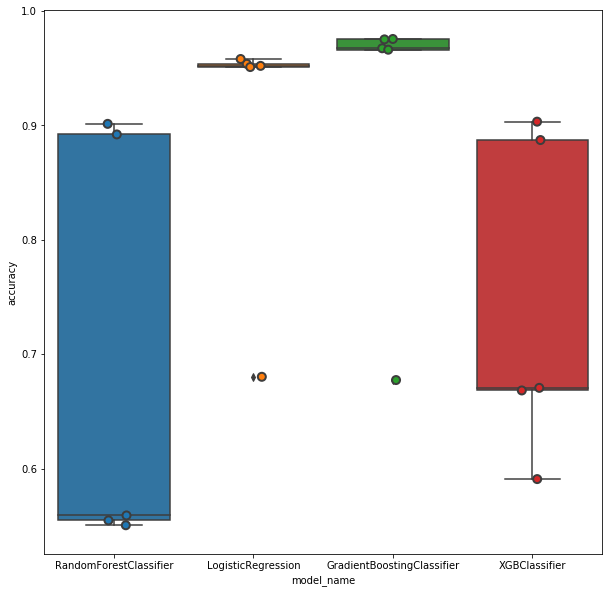

In [227]:
# !pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42),
    XGBClassifier(random_state=42,learning_rate=0.01)
    
]

cv_df = pd.DataFrame(index=range(5 * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tf, y, scoring='accuracy', cv=5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df,ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,ax=ax, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [228]:
cv_df.groupby('model_name').accuracy.mean()

model_name
GradientBoostingClassifier    0.912274
LogisticRegression            0.898963
RandomForestClassifier        0.691519
XGBClassifier                 0.744009
Name: accuracy, dtype: float64

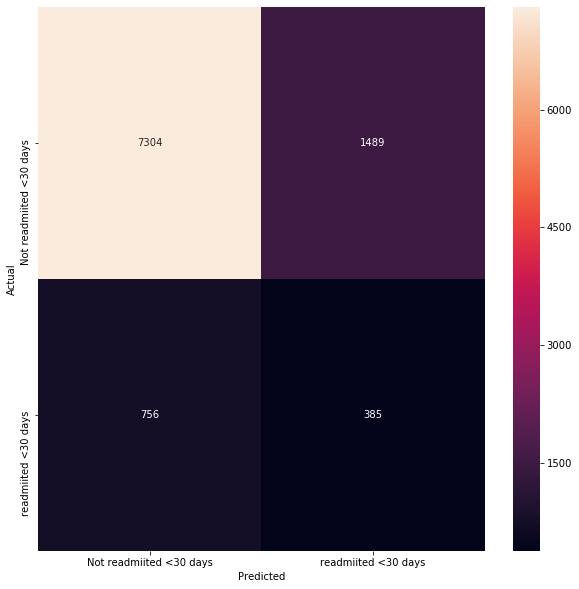

In [229]:
xgb = XGBClassifier(random_state=42,learning_rate=0.01)
xgb.fit(X_train_tf, y_train)
y_pred = xgb.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Not readmiited <30 days', 'readmiited <30 days'], yticklabels=['Not readmiited <30 days', 'readmiited <30 days'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [230]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      8793
           1       0.21      0.34      0.26      1141

    accuracy                           0.77      9934
   macro avg       0.56      0.58      0.56      9934
weighted avg       0.83      0.77      0.80      9934



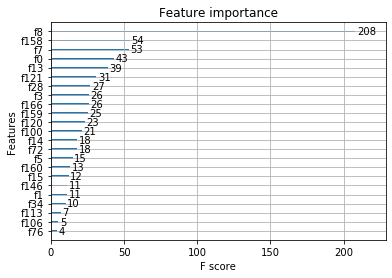

In [232]:
from matplotlib import pyplot
from xgboost import plot_importance

plot_importance(xgb)
pyplot.show()

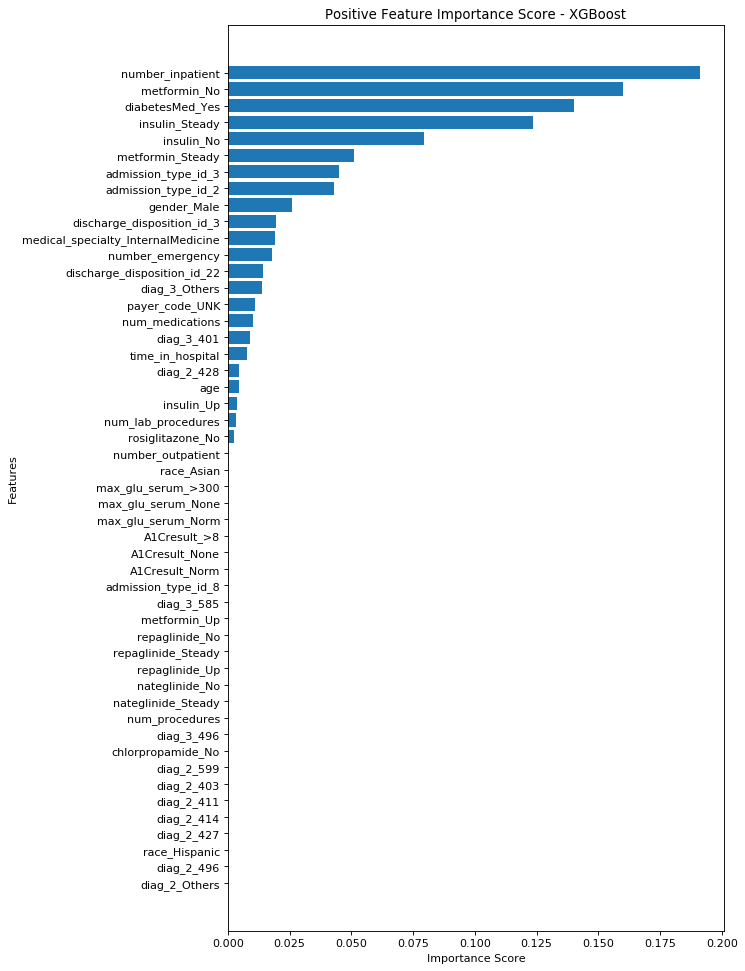

In [234]:
feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = list(all_X_train.columns),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - XGBoost')
plt.yticks(ylocs, feature_labels)
plt.show()

## Logistic regression model

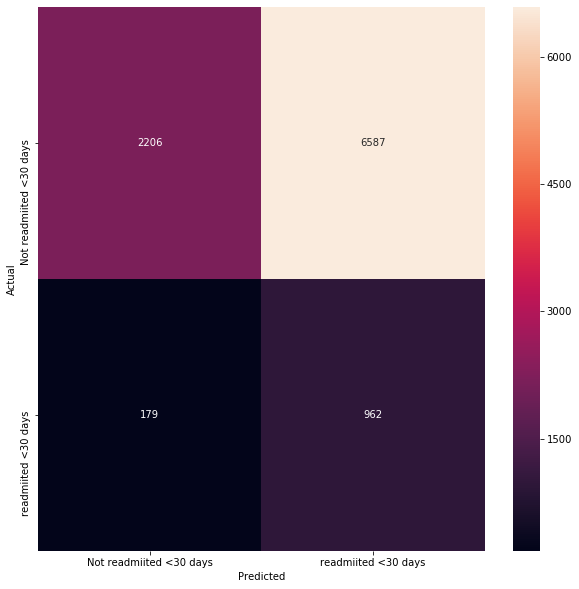

              precision    recall  f1-score   support

           0       0.92      0.25      0.39      8793
           1       0.13      0.84      0.22      1141

    accuracy                           0.32      9934
   macro avg       0.53      0.55      0.31      9934
weighted avg       0.83      0.32      0.37      9934



In [235]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf, y_train)
y_pred = lr.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Not readmiited <30 days', 'readmiited <30 days'], yticklabels=['Not readmiited <30 days', 'readmiited <30 days'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred))

## Important positive features

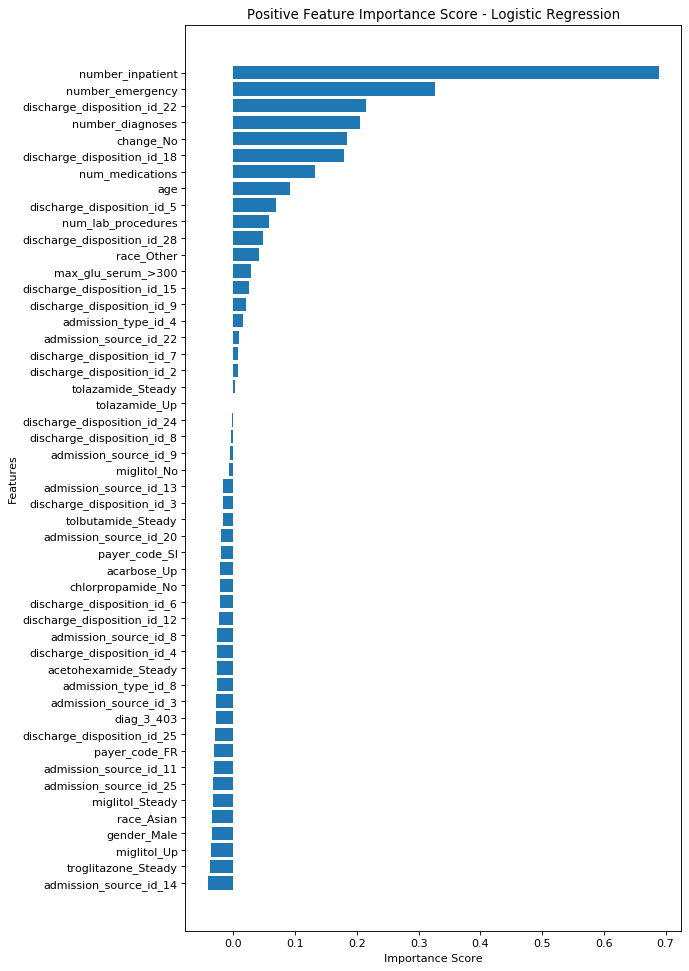

In [236]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = list(all_X_train.columns),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

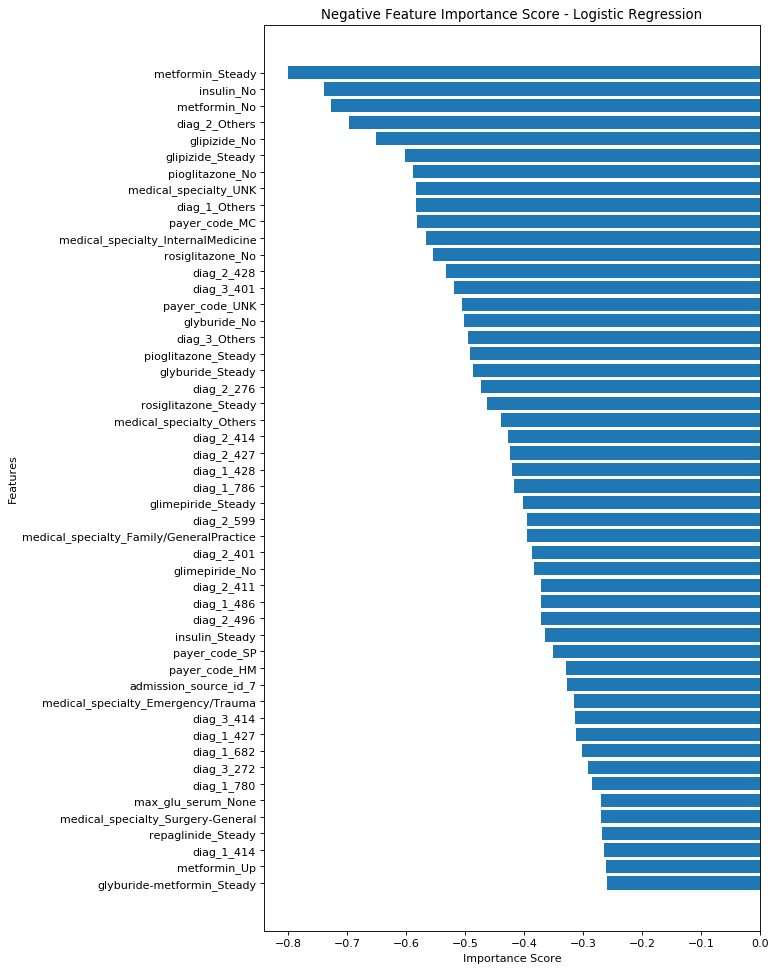

In [237]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

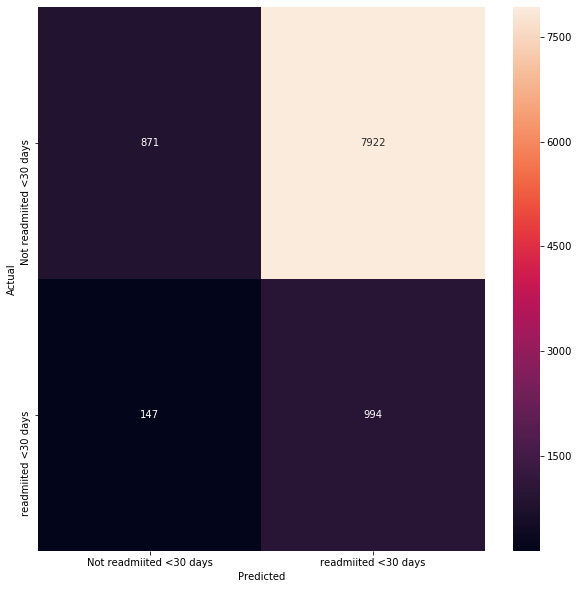

              precision    recall  f1-score   support

           0       0.86      0.10      0.18      8793
           1       0.11      0.87      0.20      1141

    accuracy                           0.19      9934
   macro avg       0.48      0.49      0.19      9934
weighted avg       0.77      0.19      0.18      9934



In [238]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gb.fit(X_train_tf, y_train)
y_pred = gb.predict(X_test)


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Not readmiited <30 days', 'readmiited <30 days'], yticklabels=['Not readmiited <30 days', 'readmiited <30 days'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred))

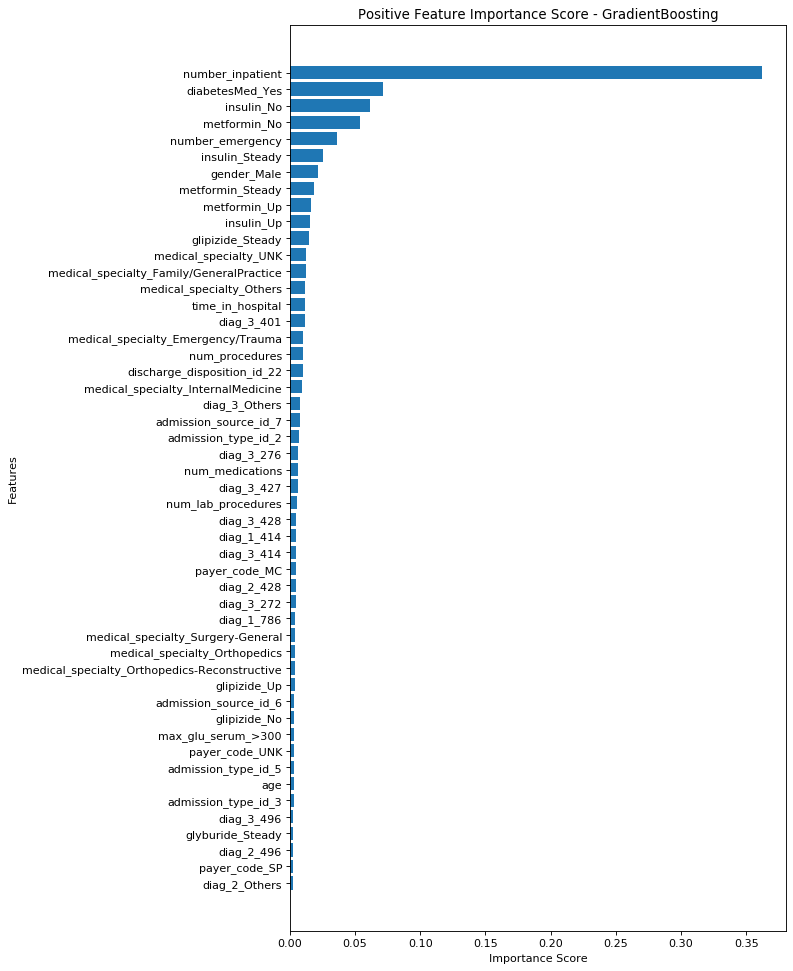

In [239]:
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = list(all_X_train.columns),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - GradientBoosting')
plt.yticks(ylocs, feature_labels)
plt.show()

In [240]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 3,random_state=42)
rf.fit(X_train_tf, y_train)
y_pred = rf.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      8793
           1       0.20      0.17      0.18      1141

    accuracy                           0.82      9934
   macro avg       0.55      0.54      0.54      9934
weighted avg       0.81      0.82      0.82      9934



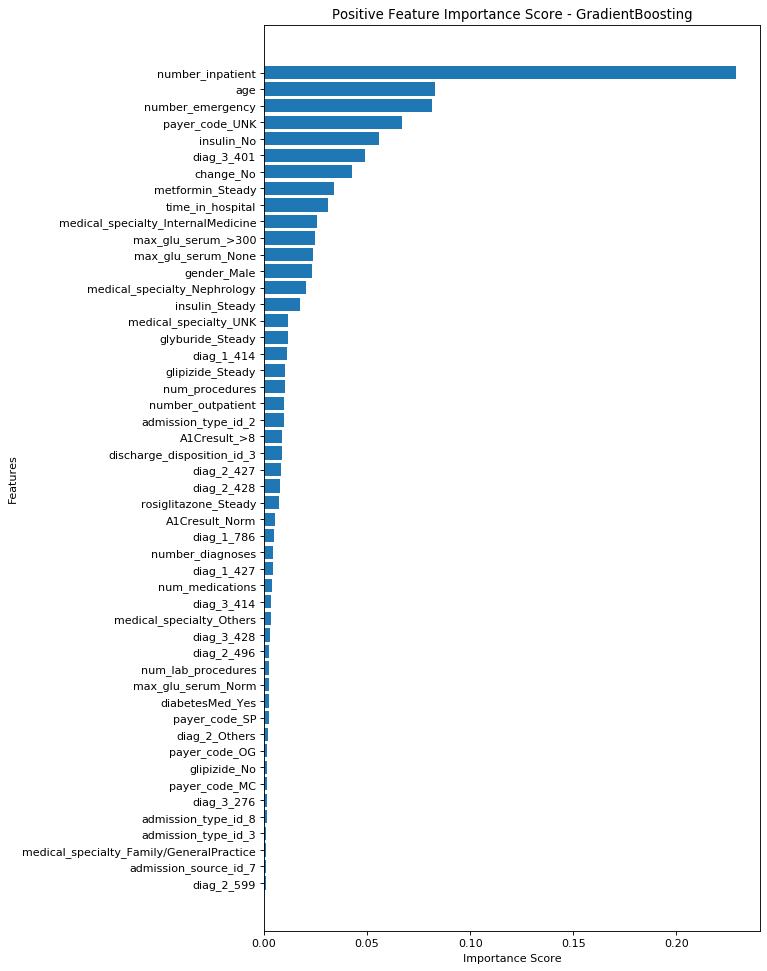

In [241]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = list(all_X_train.columns),
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - GradientBoosting')
plt.yticks(ylocs, feature_labels)
plt.show()